
# Procesamiento de lenguaje natural
## Desafio 4 - Bot QA

### Datos
 Se construirá un BOT para responder a preguntas del usuario (QA).
 Para ese desafio se utilizó el dataset disponible en:

 https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot?resource=download

 Despues se hizo un data augmentation utilizando ChatGPT v4 donde se pidió para generar 3x la cantidad de lineas pero haciendo pequeños cambios de palabras para mejorar la cantidad de datos disponibles para procesamiento.

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install tensorflow-text
!pip install pydot
!pip install graphviz
!pip install --upgrade googletrans==4.0.0-rc1

In [20]:
import re
import os
import json
import gdown

import logging
from pathlib import Path
from io import StringIO
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import plot_model

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, Input
from keras.models import Model
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

#For data augmentation
from googletrans import Translator
import nltk
from nltk.corpus import wordnet
from textblob import TextBlob
import random

In [3]:
#Cargar el archivo CSV
data = pd.read_csv('desafio_4_conversation_expanded.csv')
questions = data['question'].tolist()
answers = data['answer'].tolist()

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [4]:
#Empezamos con una limpieza de ruídos en los datos de entradas y sacamos abreviaciones para mejorar el resultado.

chat_in = []
chat_out = []
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\"", "")
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("\'ll", " will")
    txt = txt.replace("\'re", " are")
    txt = txt.replace("didn\'t", "did not")
    txt = txt.replace("wasn\'t", "was not")
    txt = txt.replace("hasn\'t", "has not")
    txt = txt.replace("I\'ve", "I have")
    txt = txt.replace("can\'t", "cannot")
    txt = re.sub(r'\W+', ' ', txt)
    return txt


In [5]:
# Limpieza del texto
questions = [clean_text(q) for q in questions]
answers = ['<START> ' + clean_text(a) + ' <END>' for a in answers]

# Tokenizando el texto
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(questions)
word2idx_inputs = tokenizer_inputs.word_index
encoder_input_sequences = tokenizer_inputs.texts_to_sequences(questions)
max_input_len = max(len(seq) for seq in encoder_input_sequences)

tokenizer_outputs = Tokenizer(filters='')
tokenizer_outputs.fit_on_texts(answers)
word2idx_outputs = tokenizer_outputs.word_index
decoder_output_sequences = tokenizer_outputs.texts_to_sequences(answers)
max_out_len = max(len(seq) for seq in decoder_output_sequences)
num_words_output = len(word2idx_outputs) + 1

encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='post')
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=max_out_len, padding='post')

# Creando secuencias del target para el decoder
decoder_targets = np.zeros((len(answers), max_out_len, num_words_output), dtype='float32')
for i, seqs in enumerate(decoder_output_sequences):
    for t, word_id in enumerate(seqs):
        if t > 0:
            decoder_targets[i, t - 1, word_id] = 1

print("word2idx_inputs:", word2idx_inputs)
print("max_input_len:", max_input_len)
print("word2idx_outputs:", word2idx_outputs)
print("max_out_len:", max_out_len)
print("num_words_output:", num_words_output)


word2idx_inputs: {'i': 1, 'you': 2, 'the': 3, 'is': 4, 'to': 5, 'it': 6, 'a': 7, 'that': 8, 'what': 9, 'are': 10, 'do': 11, 't': 12, 'did': 13, 'of': 14, 'and': 15, 'have': 16, 'will': 17, 'they': 18, 'was': 19, 'not': 20, 'in': 21, 'he': 22, 'like': 23, 'so': 24, 'my': 25, 'am': 26, 'we': 27, 'don': 28, 'for': 29, 'yes': 30, 'but': 31, 'no': 32, 'me': 33, 'on': 34, 'be': 35, 'about': 36, 'how': 37, 'go': 38, 'why': 39, 'your': 40, 'think': 41, 'too': 42, 'going': 43, 'good': 44, 'there': 45, 'with': 46, 'want': 47, 'really': 48, 'at': 49, 'know': 50, 'this': 51, 'get': 52, 'well': 53, 'one': 54, 'all': 55, 'can': 56, 'she': 57, 'would': 58, 'just': 59, 'people': 60, 'see': 61, 'if': 62, 'had': 63, 'nice': 64, 'need': 65, 've': 66, 'then': 67, 'right': 68, 'out': 69, 'time': 70, 'up': 71, 'oh': 72, 'money': 73, 'her': 74, 'should': 75, 'him': 76, 'new': 77, 'lot': 78, 'day': 79, 'when': 80, 'much': 81, 'got': 82, 'maybe': 83, 'cannot': 84, 'sure': 85, 'or': 86, 'course': 87, 'because':

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [6]:
url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
output = 'fasttext.pkl'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=be3e2da4-ed9e-4cb9-868b-2adcb340d50e
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:32<00:00, 89.2MB/s]


'fasttext.pkl'

In [7]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [8]:
class FasttextEmbeddings(WordsEmbeddings):
    PKL_PATH = 'fasttext.pkl'  # Utilizamos el pkl bajado anteriormente
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

    def __init__(self, pkl_path='fasttext.pkl'):
        self.PKL_PATH = pkl_path
        super().__init__()


# Cargando FastText embeddings
fasttext_embeddings = FasttextEmbeddings()

# Creamos la matrix de embeddings usando los embeddings cargados FastText
embedding_dim = 300
embedding_matrix = np.zeros((len(word2idx_inputs) + 1, embedding_dim))
for word, i in word2idx_inputs.items():
    embedding_vector = fasttext_embeddings.get_words_embeddings([word])
    if embedding_vector is not None and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector[0]

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding

# Define el encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding = Embedding(len(word2idx_inputs) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_input_len, trainable=False)(encoder_inputs)
encoder_lstm = LSTM(512, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define el decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, embedding_dim, input_length=max_out_len, trainable=True)(decoder_inputs)
decoder_lstm = LSTM(512, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


# Define el model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilamos el model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 22)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 20, 300)        │        704,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 22, 300)        │        722,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,665,024 │ embedding[0][0]        │
│                           │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 22, 512),      │      1,665,024 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 22, 2408)       │      1,235,304 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,991,852 (22.86 MB)

 Trainable params: 5,287,752 (20.17 MB)

 Non-trainable params: 704,100 (2.69 MB)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores.

In [10]:
from tensorflow.keras.utils import to_categorical

decoder_target_data = np.zeros((len(answers), max_out_len, num_words_output), dtype='float32')
for i, target_seq in enumerate(decoder_output_sequences):
    for t, word in enumerate(target_seq):
        if t > 0:
            decoder_target_data[i, t - 1, word] = 1.0

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Stop after 3 epochs of no improvement


# Entrenamos el modelo
hist = model.fit([encoder_input_sequences, decoder_output_sequences],
          decoder_target_data,
          batch_size=64,
          epochs=80,
          validation_split=0.2,
          callbacks=[early_stopping])


Epoch 1/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.6458 - loss: 2.8652 - val_accuracy: 0.6947 - val_loss: 1.9226
Epoch 2/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7040 - loss: 1.8108 - val_accuracy: 0.7090 - val_loss: 1.7440
Epoch 3/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.7214 - loss: 1.6272 - val_accuracy: 0.7195 - val_loss: 1.6091
Epoch 4/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.7276 - loss: 1.5173 - val_accuracy: 0.7250 - val_loss: 1.5058
Epoch 5/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.7351 - loss: 1.4147 - val_accuracy: 0.7304 - val_loss: 1.4131
Epoch 6/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.7420 - loss: 1.3197 - val_accuracy: 0.7356 - val_loss: 1.3300
Epoch 7/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.7472 - loss: 1.2456 - val_accuracy: 0.7422 - val_loss: 1.2560
Epoch 8/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.7544 - loss: 1.1765

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [15]:
# Definimos el modelo encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Definimos el modelo decoder
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c = Input(shape=(512,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Definimos una function para generar las respuestas
def generate_response(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word2idx_outputs['<start>']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    previous_word = "" # keep track of the previous word
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tokenizer_outputs.index_word.get(sampled_token_index, '')

        if sampled_token == '<end>' or len(decoded_sentence) > max_out_len:
            stop_condition = True
        elif sampled_token != "" and sampled_token != previous_word: # prevent repetition
            decoded_sentence += ' ' + sampled_token
            previous_word = sampled_token # update the previous word

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update states
            states_value = [h, c]
        else:
            #If the word is repeated, try the second most likely word
            output_tokens[0,-1,sampled_token_index] = 0 #Zero out the most likely word to avoid repetition
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = tokenizer_outputs.index_word.get(sampled_token_index, '')
            if sampled_token != "" and sampled_token != previous_word:
                decoded_sentence += ' ' + sampled_token
                previous_word = sampled_token
                target_seq = np.zeros((1, 1))
                target_seq[0, 0] = sampled_token_index
                states_value = [h, c]
            else:
                stop_condition = True #give up if the second word is also the same


    return decoded_sentence.strip()


In [22]:
def answer_question(input_text):
    cleaned_input_text = clean_text(input_text)

    # Tokenizar
    input_sequence = tokenizer_inputs.texts_to_sequences([cleaned_input_text])
    input_sequence = pad_sequences(input_sequence, maxlen=max_input_len, padding='post')

    # Genera una respuesta
    response = generate_response(input_sequence)
    print('Input:', input_text) # Print pregunta original
    print('Response:', response)

answer_question("How was your day?")
answer_question("how's it going?")
answer_question("what happened?")
answer_question("what happened to your car?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Input: How was your day?
Response: i was told about it already
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Input: how's it going?
Response: i am having a party this
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input

#### 6 - Detalles del modelo

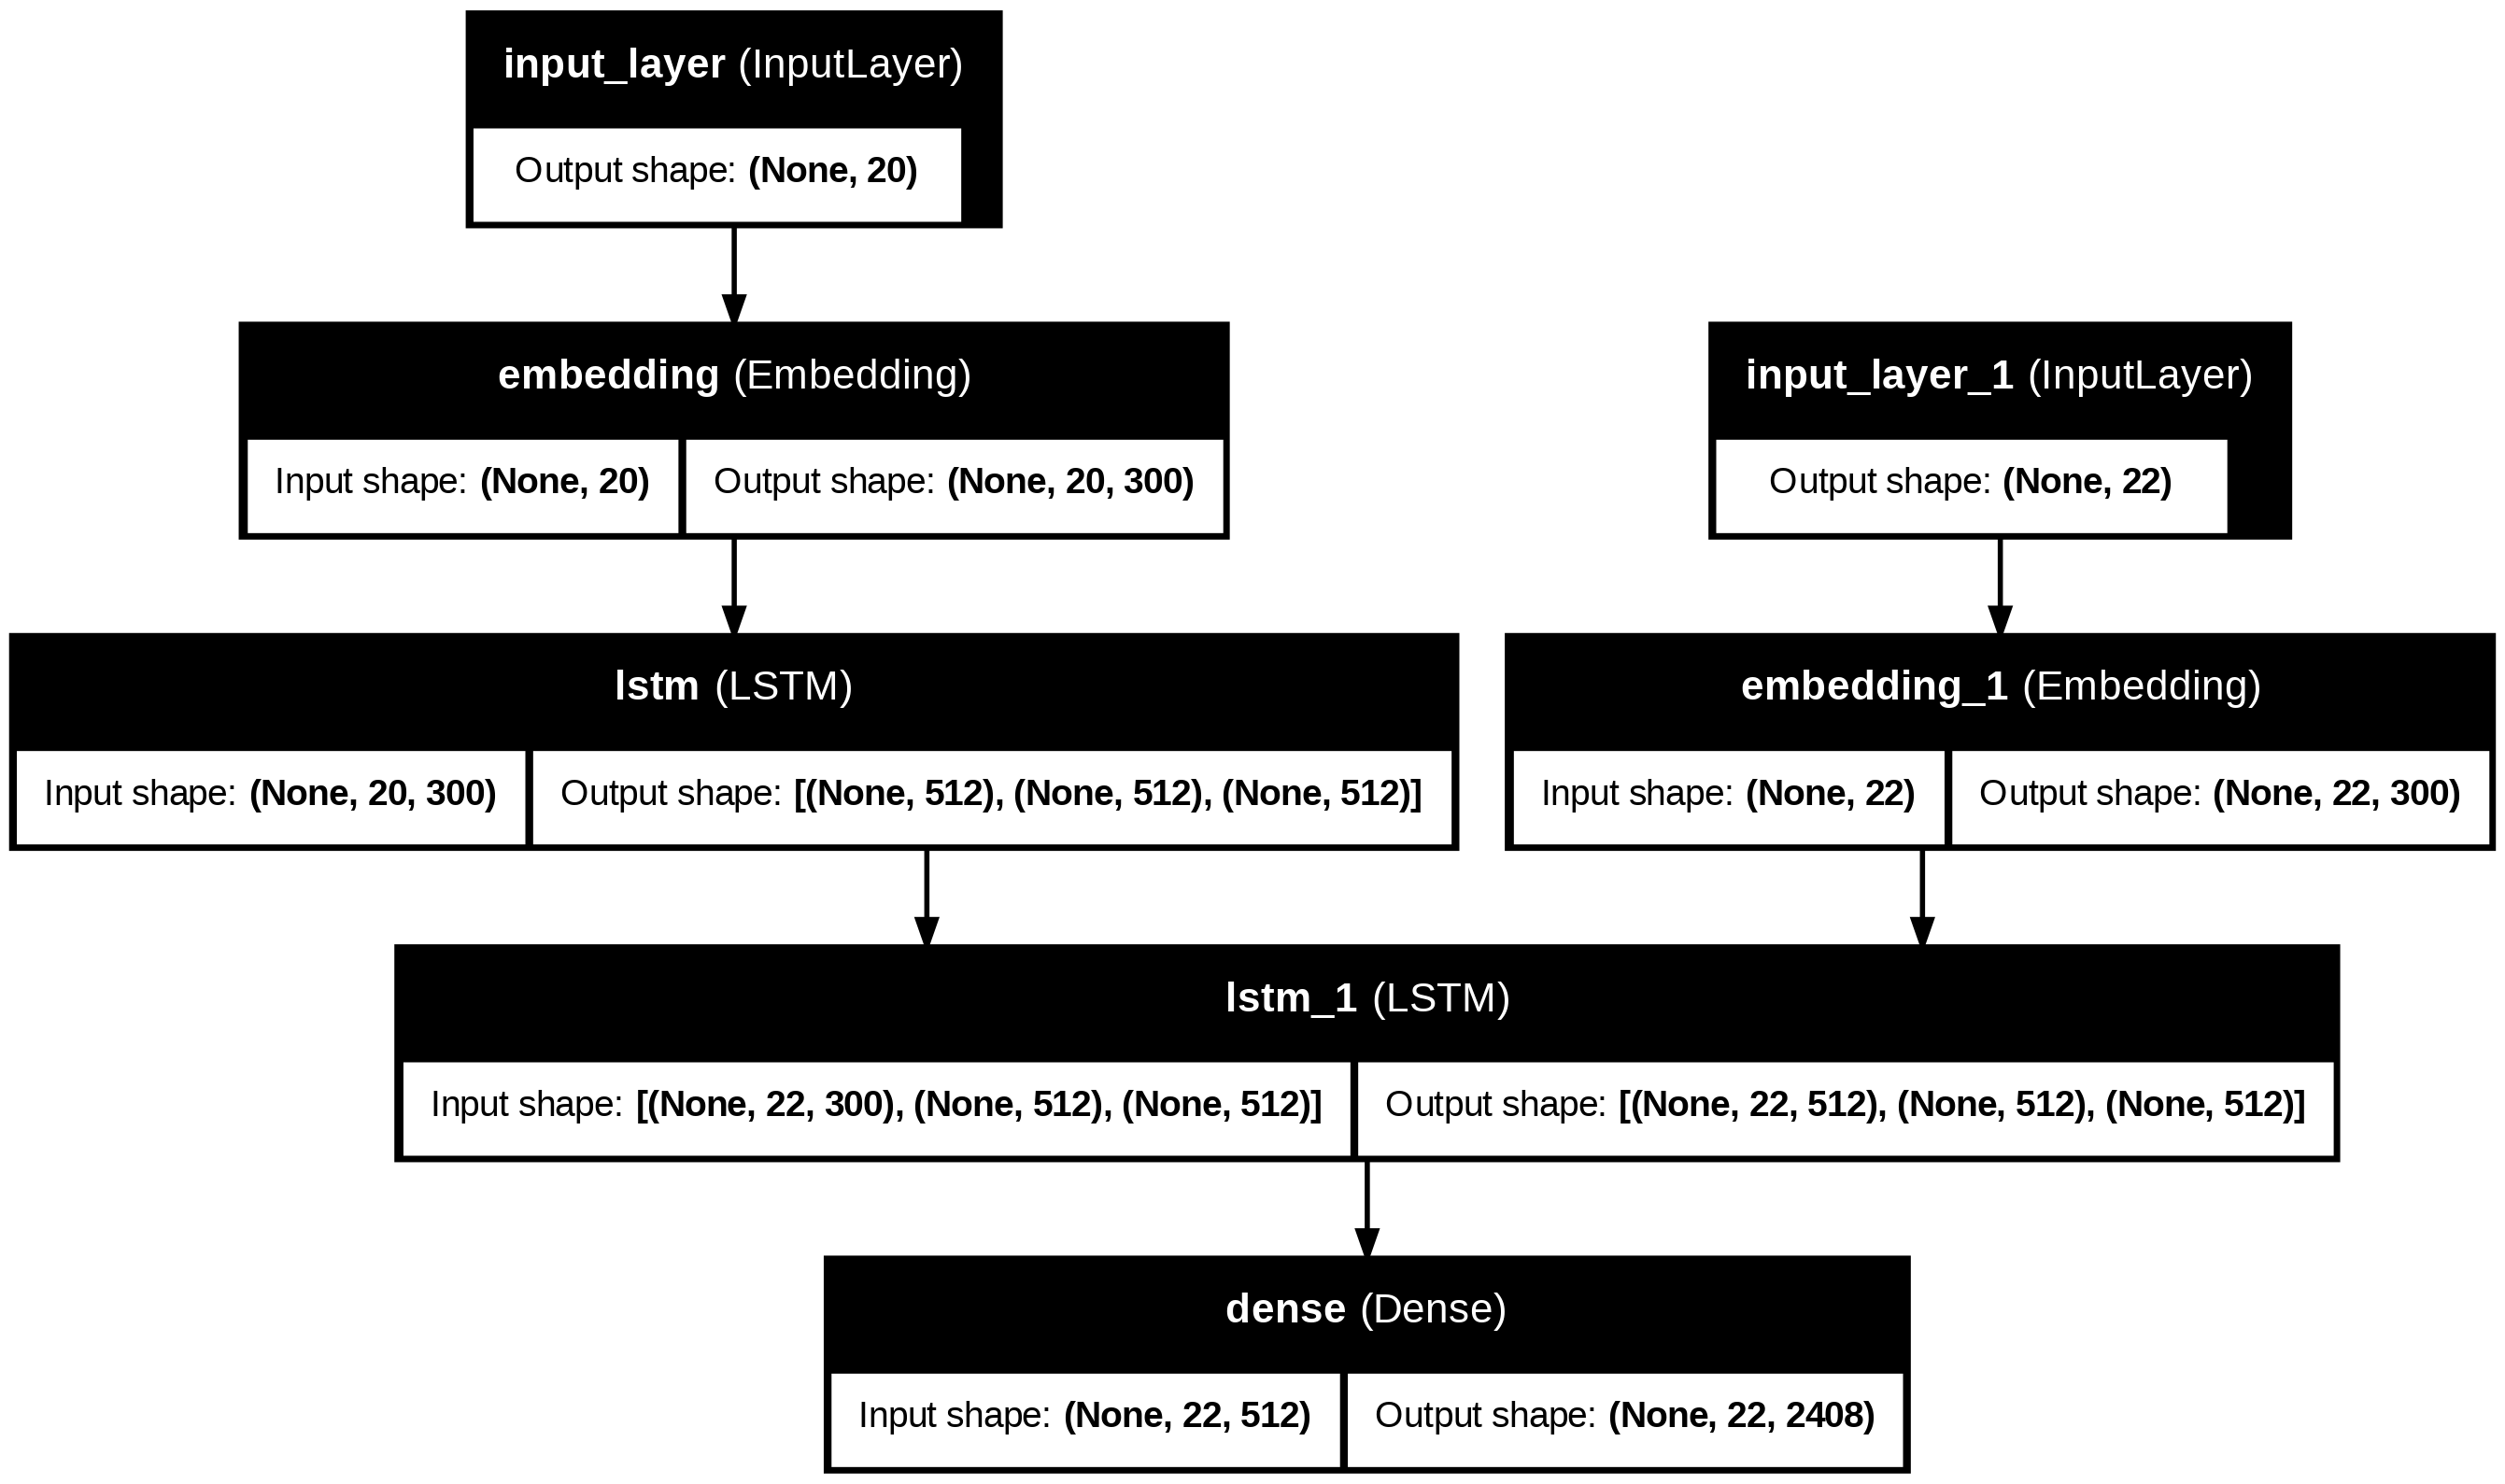

In [18]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Metricas

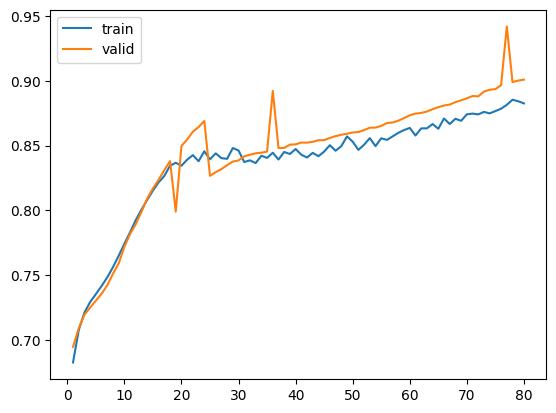

In [21]:
# Entrenamiento - Resultado
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

# Conclusión

El modelo de encoder-decoder, entrenado con embeddings de FastText de 300 dimensiones, muestra una capacidad aceptable para responder preguntas en inglés, aunque con limitaciones.
La precisión del modelo durante el entrenamiento, reflejada en la curva de aprendizaje, indica un buen ajuste a los datos de entrenamiento pero con una brecha entre el desempeño en el conjunto de entrenamiento y validación. Esto podría sugerir un sobreajuste a los datos de entrenamiento, por lo que un ajuste más fino de hiperparámetros (como el número de epochs, el tamaño del batch o la tasa de aprendizaje) podría mejorar la generalización del modelo a datos no vistos.

Creo que con un aumento de datos de entrenamiento incluyendo mayor calidad y diversidad mejorararía significativamente la capacidad del modelo para generalizar y responder a preguntas más complejas, pero eso podría necesitar mas poder de computa y memoria, incluyendo mas tiempo en entrenamiento. Se incrementó mas neuronas en LSTM para 512 en el intento de mejorar los resultados de validación, pero no fue posible avanzar en la cantidad por la restrición de los recursos de procesamiento disponibles.

Creo también que una mejora en el preprocesamiento del texto, incluyendo la corrección de errores ortográficos y agregar formas distintas de hacer las mismas questiones permitiría una mejor comprensión del lenguaje de entrada, permitiendo un mejor resultado de salida.

En resumen, el modelo presenta un punto de partida funcional para un chatbot de preguntas y respuestas en ingles, pero requiere mejoras en la generalización y la fluidez de las respuestas para un funcionamiento óptimo en escenarios reales.